### Step 1: Install dependencies for model evaluation 🔽

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common \
    patchelf \
    xvfb

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


### Step 2: Install and import the packages 📦

---





In [2]:
!pip install gym==0.21.0
!pip install free-mujoco-py
!pip install transformers
!pip install datasets
!pip install imageio-ffmpeg
!pip install torch

!pip install colabgymrender==1.0.2
!pip install xvfbwrapper
!pip install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install huggingface_hub


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached imageio-2.31.1-py3-none-any.whl (313 kB)
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached imageio-2.4.1-py3-none-any.whl
  Attempting uninstall: imageio
    Foun

In [1]:
import os
import random
from dataclasses import dataclass

import numpy as np
import torch
from datasets import load_dataset, DatasetDict, Dataset
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

/home/hamid/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["WANDB_DISABLED"] = "true" # we diable weights and biases logging for this tutorial
# dataset = load_dataset("edbeeching/decision_transformer_gym_replay", "halfcheetah-expert-v2")
import csv
MARKET = 'EURUSD_4H'
types = {'observations' : float, 'next_observations' : float, 'actions' : float , 'rewards' : float, 'dones' : float}
dataset = load_dataset('csv', data_files='./Data/{}_trajectories_5.csv'.format(MARKET))

Found cached dataset csv (/home/hamid/.cache/huggingface/datasets/csv/default-564e251213bdd279/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)
100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


In [3]:
print(dataset)
print((dataset['train']['observations'][0]))

DatasetDict({
    train: Dataset({
        features: ['observations', 'next_observations', 'actions', 'rewards', 'dones'],
        num_rows: 5000
    })
})
[[0.9699592982023373, -0.6666666666666666, -0.4, -0.4, 0.543992892979347, 0.4351321516397763], [0.9741759427708058, -0.6666666666666666, -0.8, -0.4, 0.8931182239837783, 0.08222802969676704], [0.9771669082051124, 0.3333333333333333, -0.8, -0.8, 0.30831665652775553, 0.6751695390943429], [0.9761879066325431, 0.3333333333333333, -0.6, -0.8, 0.10766421577113487, 0.8784062429538507], [0.9757870555949555, -0.3333333333333333, 0.6, -0.6, 0.032224577320063744, 0.9547945608122697], [0.9759874811137492, 0.3333333333333333, 0.4, 0.2, 0.5138771164885693, 0.4670465485594814], [0.9741605254232063, 0.3333333333333333, -0.4, -0.2, 0.20476590511166878, 0.7795652676899509], [0.9732817366100337, 0.3333333333333333, -0.6, 0.8, 0.006320129000115188, 0.9799668722978376], [0.9732431932410349, 0.6666666666666666, -0.4, -0.6, 0.8508874215039564, 0.1270352169

In [4]:
import ast
import pandas as pd

ds = pd.DataFrame([])
observations = []
actions = []
dones = []
next_observations = []
rewards = []
train = {}

for l in dataset["train"]['observations']:
  observations.append(ast.literal_eval(l))
train['observations'] = observations

for l in dataset["train"]['actions']:
  actions.append(ast.literal_eval(l))
train['actions'] = actions

for l in dataset["train"]['rewards']:
  rewards.append(ast.literal_eval(l))
train['rewards'] = rewards

for l in dataset["train"]['next_observations']:
  next_observations.append(ast.literal_eval(l))
train['next_observations'] = next_observations

for l in dataset["train"]['dones']:
  dones.append(ast.literal_eval(l))
train['dones'] = dones


In [5]:
print(type(train['actions'][0][0][0]))

<class 'float'>


In [6]:
import pyarrow as pa

pa_train = pa.Table.from_pydict(train)

idk = Dataset(pa_train)
print(type(idk))

<class 'datasets.arrow_dataset.Dataset'>


In [7]:
dd = DatasetDict({"train": idk})
print(dd)

DatasetDict({
    train: Dataset({
        features: ['observations', 'actions', 'rewards', 'next_observations', 'dones'],
        num_rows: 5000
    })
})


### Step 4: Defining a custom DataCollator for the transformers Trainer class

In [8]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 20 #subsets of the episode we use for training
    state_dim: int = 6  # size of state space
    act_dim: int = 2  # size of action space
    max_ep_len: int = 500 # max episode length in the dataset
    scale: float = 1000.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = len(dataset[0]["actions"][0])
        print(self.act_dim)
        self.state_dim = len(dataset[0]["observations"][0])
        print(self.state_dim)
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for obs in dataset["observations"]:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
        
        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1)

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

### Step 5: Extending the Decision Transformer Model to include a loss function

In order to train the model with the 🤗 trainer class, we first need to ensure the dictionary it returns contains a loss, in this case L-2 norm of the models action predictions and the targets.

In [9]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [10]:
collator = DecisionTransformerGymDataCollator(dd["train"])

config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)

2
6


### Step 6: Defining the training hyperparameters and training the model
Here, we define the training hyperparameters and our Trainer class that we'll use to train our Decision Transformer model.

This step takes about an hour, so you may leave it running. Note the authors train for at least 3 hours, so the results presented here are not as performant as the models hosted on the 🤗 hub.

In [17]:
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=32,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dd["train"],
    data_collator=collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
 20%|█▉        | 500/2528 [05:42<21:15,  1.59it/s]

{'loss': 0.1329, 'learning_rate': 8.914285714285715e-05, 'epoch': 6.33}


 40%|███▉      | 1000/2528 [11:30<19:42,  1.29it/s]

{'loss': 0.1329, 'learning_rate': 6.716483516483517e-05, 'epoch': 12.66}


 59%|█████▉    | 1501/2528 [18:21<08:10,  2.10it/s]

{'loss': 0.1327, 'learning_rate': 4.5186813186813186e-05, 'epoch': 18.99}


 79%|███████▉  | 2000/2528 [24:02<05:36,  1.57it/s]

{'loss': 0.1326, 'learning_rate': 2.320879120879121e-05, 'epoch': 25.32}


 99%|█████████▉| 2500/2528 [29:46<00:17,  1.60it/s]

{'loss': 0.1327, 'learning_rate': 1.2307692307692308e-06, 'epoch': 31.65}


100%|██████████| 2528/2528 [30:05<00:00,  1.40it/s]

{'train_runtime': 1805.905, 'train_samples_per_second': 88.598, 'train_steps_per_second': 1.4, 'train_loss': 0.13275951826119725, 'epoch': 32.0}


TrainOutput(global_step=2528, training_loss=0.13275951826119725, metrics={'train_runtime': 1805.905, 'train_samples_per_second': 88.598, 'train_steps_per_second': 1.4, 'train_loss': 0.13275951826119725, 'epoch': 32.0})

In [12]:
trainer.save_model('./models/model11')

In [16]:
trainer = DecisionTransformerModel.from_pretrained('./models/model10/')

### Step 7: Visualize the performance of the agent

In [19]:
import gym

from colabgymrender.recorder import Recorder

In [18]:
import pandas as pd
import random
import numpy as np
from random import shuffle

BUY_ACTION_TOP = 0.4
SELL_ACTION_LOW = 0.6
T1_start = 10
T2_start = 1000
MARKET = 'EURUSD_4H'
dataset = pd.read_csv('./Data/{}_Cleaned.csv'.format(MARKET))
MAX_DAYS_IN_POSITION = 20


class Environment():
  def __init__(self, config):
    self.dataset = dataset
    self.config = config
    self.time = 0
    self.maxtime = len(self.dataset)
    self.orders = []

  # actions : [sell witch token, percent, period]
  # 1 : token A (€)
  # 2 : token B ($)
  # 0 : do nothing
  def take_action(self, action, budget):
    # print('Start budget at day #{} : {}'.format(self.time, budget))
    price = self.dataset.loc[self.time, 'open']
    token_a_change, token_b_change = self.rebalance()
    budget[0] += token_a_change
    budget[1] += token_b_change
    budget_update = budget
    terminal = False
    future_networth = 0
    current_networth = budget[0] * price + budget[1]
    reward = 0
    # print('Budget after rebalance at day #{} : {}'.format(self.time, budget))

    if 0 <= action[0] < BUY_ACTION_TOP: # euro -> dollar
      percent = action[0] / BUY_ACTION_TOP
      percent = 1 - percent
      token_a = budget[0]
      token_b = budget[1]
      token_a_to_sell = token_a * percent # we have number of 'token a' that agent wants to sell
      token_b_to_buy = token_a_to_sell * price
      budget_update = [token_a - token_a_to_sell, token_b + token_b_to_buy]
      duration = int(action[1] * MAX_DAYS_IN_POSITION)
      self.orders.append([action[0], token_b_to_buy, duration])
      future_networth = self.future(action[0], token_b_to_buy, self.time+duration, budget)
      reward = future_networth - current_networth
      # print('Budget after take action(1) at day #{} : {} with {} percent'.format(self.time, budget_update, percent))

    elif SELL_ACTION_LOW < action[0] <= 1: # dollar -> euro
      percent = (action[0] - SELL_ACTION_LOW) / BUY_ACTION_TOP
      token_a = budget[0]
      token_b = budget[1]
      token_b_to_sell = token_b * percent # we have number of 'token b' that agent wants to sell
      token_a_to_buy = token_b_to_sell / price
      budget_update = [token_a + token_a_to_buy, token_b - token_b_to_sell]
      duration = int(action[1] * MAX_DAYS_IN_POSITION)
      self.orders.append([action[0], token_a_to_buy, duration])
      future_networth = self.future(action[0], token_a_to_buy, self.time+duration, budget)
      reward = future_networth - current_networth
      # print('Budget after take action(2) at day #{} : {} with {} percent'.format(self.time, budget_update, percent))


    self.time += 1
    next_state = self.next_state(budget_update)

    if self.time == self.maxtime:
      terminal = True
    self
    return budget_update, next_state, (reward), terminal
      

  def reset(self):
    self.time = 0
    self.orders = []
    budget = [T1_start, T2_start]
    s = np.array(self.next_state(budget))
    return s

  def future(self, action, token, time, budget):
    token_a_change = 0
    token_b_change = 0
    price = self.dataset.loc[time, 'open']
    if 0 <= action <= BUY_ACTION_TOP:
      token_a_change = token / price
      token_b_change = -1 * token
    elif SELL_ACTION_LOW <= action <= 1:
      token_b_change = token * price
      token_a_change = -1 * token

    token_a_future = budget[0] + token_a_change
    token_b_future = budget[1] + token_b_change
    future_networth = token_a_future * price + token_b_future
    return future_networth


  def get_networth(self, budget):
    price = self.dataset.loc[self.time, 'open']
    return budget[0] * price + budget[1]
  
  
  def rebalance(self):
    token_a_change = 0
    token_b_change = 0
    for item in self.orders:
      if self.time == item[2]:
        price = self.dataset.loc[self.time, 'open']
        if 0 <= item[0] <= BUY_ACTION_TOP:
          token_a_change = item[1] / price
          token_b_change = -1 * item[1]
        elif SELL_ACTION_LOW <= item[0] <= 1:
          token_b_change = item[1] * price
          token_a_change = -1 * item[1]

    return token_a_change, token_b_change

  def next_state(self, budget):
    open = self.dataset.loc[self.time, 'open']
    close = self.dataset.loc[self.time, 'close']
    high = self.dataset.loc[self.time, 'high']
    low = self.dataset.loc[self.time, 'low']
    body_atr = self.dataset.loc[self.time , 'bodyatr_buck']
    up_atr = self.dataset.loc[self.time , 'upperatr_buck']
    low_atr = self.dataset.loc[self.time , 'loweratr_buck']
    # obs = [open, close, high, low, body_atr, up_atr, low_atr, budget[0], budget[1]]
    obs = [close, body_atr, up_atr, low_atr, budget[0], budget[1]]
    return obs



In [19]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

In [20]:
config = {}
env = Environment(config)

# Interact with the environment and create a video
episode_return, episode_length = 0, 0
max_ep_len = 500
device = "cpu"
scale = 1000.0  # normalization for rewards/returns
TARGET_RETURN = 500000  # evaluation is conditioned on a return of 12000, scaled accordingly
state_dim = 6
act_dim = 2
state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)

networths = []
budget = [10, 1000]

state = env.reset()
target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(0, device=device, dtype=torch.float32)

timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
for t in range(max_ep_len):
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1, device=device)])

    action = get_action(
        model,
        (states - state_mean) / state_std,
        actions,
        rewards,
        target_return,
        timesteps,
    )
    print(action)
    actions[-1] = action
    action = action.detach().cpu().numpy()

    budget_update, next_state, reward, done = env.take_action(action, budget)
    print('REWARD: {}'.format(reward))
    next_state = np.array(next_state)
    budget = budget_update

    cur_state = torch.from_numpy(next_state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[-1] = reward
    # print('reward: {}'.format(reward))

    pred_return = target_return[0, -1] - (reward)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    print('PRED_RETURN: {}'.format(pred_return))
    timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

    episode_return += reward
    episode_length += 1

    networth = env.get_networth(budget)
    print('Networth:{}'.format(networth))
    networths.append(networth)

    if done:
        break

tensor([0.4818, 0.4575], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2157.81
tensor([0.4715, 0.4538], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2154.3
tensor([0.4684, 0.4546], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2155.64
tensor([0.4913, 0.4744], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2155.2799999999997
tensor([0.4807, 0.4547], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2154.15
tensor([0.4672, 0.4582], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2153.09
tensor([0.4883, 0.4601], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2152.83
tensor([0.4873, 0.4711], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2154.19
tensor([0.4696, 0.4529], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000.0
Networth:2156.21
tensor([0.4818, 0.4758], grad_fn=<SelectBackward0>)
REWARD: 0
PRED_RETURN: 500000

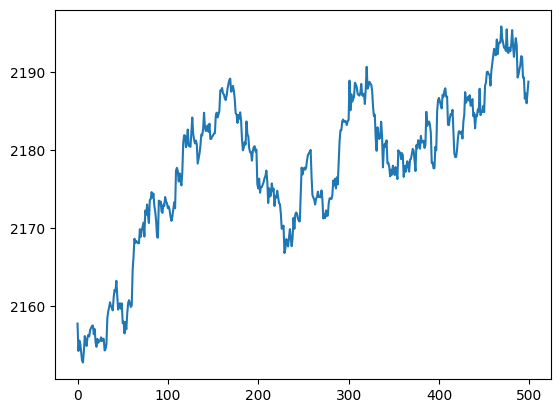

In [16]:
import matplotlib.pyplot as plt

plt.plot(networths)
plt.show()

In [ ]:
# build the environment
directory = './video'
model = model.to("cpu")
env = gym.make("HalfCheetah-v3")
env = Recorder(env, directory, fps=30)
max_ep_len = 1000
device = "cpu"
scale = 1000.0  # normalization for rewards/returns
TARGET_RETURN = 12000 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
print(state_mean)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
# Create the decision transformer model

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)


In [ ]:
# Interact with the environment and create a video
episode_return, episode_length = 0, 0
state = env.reset()
target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(0, device=device, dtype=torch.float32)

timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
for t in range(max_ep_len):
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1, device=device)])

    action = get_action(
        model,
        (states - state_mean) / state_std,
        actions,
        rewards,
        target_return,
        timesteps,
    )
    actions[-1] = action
    action = action.detach().cpu().numpy()

    state, reward, done, _ = env.step(action)

    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[-1] = reward

    pred_return = target_return[0, -1] - (reward / scale)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

    episode_return += reward
    episode_length += 1

    if done:
        break


In [ ]:
# Play the video
env.play()
# If you want to convert the video:
# !ffmpeg -i {your_video} -vcodec h264 replay.mp4 

### Step 8: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

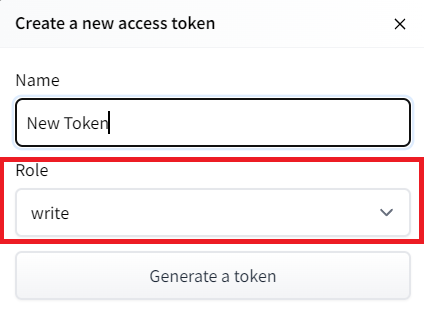

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained model to the 🤗 Hub 🔥 !!

In [ ]:
trainer.push_to_hub()

## Some additional challenges 🏆
Congratulations, you've just trained your first Decision Transformer 🥳.

Now, the best way to learn **is to try things by your own**! Why not trying with another environment?

We provide datasets for some other environments:
* [Walker2D](https://huggingface.co/edbeeching/decision-transformer-gym-walker2d-expert)
* [Hopper](https://huggingface.co/edbeeching/decision-transformer-gym-hopper-expert)


Have fun!

### Keep Learning, Stay awesome 🤗
